# Imports & Resources

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from keras.utils import np_utils

# fix the pip install
#from keras_visualizer import visualizer

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/bpberry0324/animal_shelter_outcomes/main/datasets/main.csv')

In [ ]:
df.head()

,animal_id_in,animal_type,color,breed,intake_type,outcome_type,intake_condition,outcome_subtype,datetime_in,datetime_out,year_in,month_in,day_in,year_out,month_out,day_out,prev_adoption,prev_transfer,prev_ret_to_owner,prev_rto_adopt,prev_disposal,prev_missing,prev_relocate,age_upon_outcome,age_upon_intake,sex_upon_intake,sex_upon_outcome,is_named_in,is_named_out,found_location,name_in,name_out
0,A006100,Dog,yellow white,spinone italiano mix,Public Assist,Return to Owner,Normal,Unknown,2014-12-19 10:21:00,2014-12-20 16:35:00,2014,12,Friday,2014,12,Saturday,0,0,1,0,0,0,0,7.0,7.0,Neutered Male,Neutered Male,1,1,8700 Research Blvd in Austin (TX),Scamp,Scamp
1,A006100,Dog,yellow white,spinone italiano mix,Public Assist,Return to Owner,Normal,Unknown,2014-03-07 14:26:00,2014-03-08 17:10:00,2014,3,Friday,2014,3,Saturday,0,0,0,0,0,0,0,6.0,6.0,Neutered Male,Neutered Male,1,1,8700 Research in Austin (TX),Scamp,Scamp
2,A047759,Dog,tricolor,dachshund,Owner Surrender,Transfer,Normal,Partner,2014-04-02 15:55:00,2014-04-07 15:12:00,2014,4,Wednesday,2014,4,Monday,0,0,0,0,0,0,0,1.0,1.0,Neutered Male,Neutered Male,1,1,Austin (TX),Oreo,Oreo
3,A134067,Dog,brown white,sheepdog shetland,Public Assist,Return to Owner,Injured,Unknown,2013-11-16 09:02:00,2013-11-16 11:54:00,2013,11,Saturday,2013,11,Saturday,0,0,0,0,0,0,0,1.0,1.0,Neutered Male,Neutered Male,1,1,12034 Research Blvd in Austin (TX),Bandit,Bandit
4,A141142,Dog,white black,retriever labrador bull pit,Stray,Return to Owner,Aged,Unknown,2013-11-16 14:46:00,2013-11-17 11:40:00,2013,11,Saturday,2013,11,Sunday,0,0,0,0,0,0,0,1.0,1.0,Spayed Female,Spayed Female,1,1,Austin (TX),Bettie,Bettie


# Pre-processing

In [ ]:
df = df.drop(columns=['datetime_in', 'datetime_out', 'name_out', 'name_in', 'day_out', 
                      'month_out', 'year_out', 'found_location'])

In [ ]:
df_dummied = df.copy().drop(columns=['animal_id_in','outcome_subtype','outcome_type'])
df_dummied = pd.get_dummies(df_dummied, drop_first=True)
df_dummied['animal_id_in'] = df['animal_id_in']
df_dummied['outcome_subtype'] = df['outcome_subtype']
df_dummied['outcome_type'] = df['outcome_type']

df = df_dummied

In [ ]:
X = df.drop(columns=['animal_id_in','outcome_type','outcome_subtype'])
y = df['outcome_type']

In [ ]:
# making our label categorical
encoder = LabelEncoder()
encoded_y = encoder.fit_transform(y)
y = np_utils.to_categorical(encoded_y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=13, 
                                                    stratify=y,
                                                    test_size=.2)
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

# Sequential Neural Network

In [ ]:
def animal_outcome_engine():
  model = Sequential()
  model.add(Dense(512, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=l2(.001)))
  model.add(Dropout(0.25))

  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.25))

  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.25))

  model.add(Dense(9, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
model = animal_outcome_engine()
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, 
                           verbose=1, mode='auto')
history = model.fit(X_train_sc, y_train, 
                    validation_data=(X_test_sc, y_test),
                    epochs=50, 
                    batch_size=64,
                    verbos=1, 
                    callbacks=[early_stop])

## Metrics

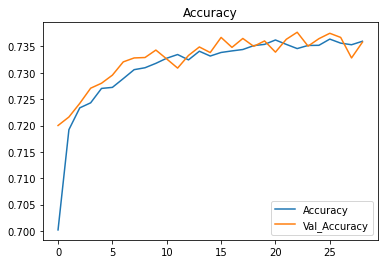

In [ ]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy');

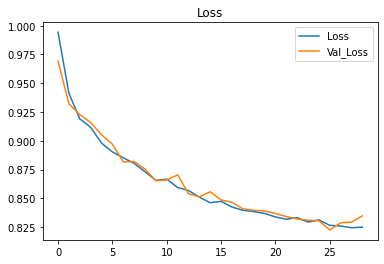

In [ ]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss');

## Saving

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/animal_shelter_testing/animal_engine.h5')

## Topology

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 512)               1293312   
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_16 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 9)                

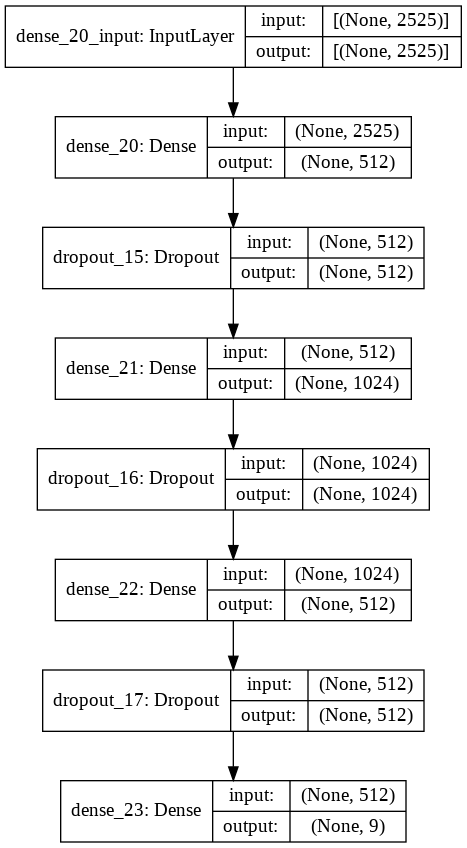

In [ ]:
tf.keras.utils.plot_model(model,
                          show_shapes=True,
                          show_layer_names=True) 

# Random Forest

In [ ]:
clf = RandomForestClassifier(max_depth=None, random_state=13)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=13, verbose=0,
                       warm_start=False)

## Scoring

In [ ]:
# Training Data Should Be Near 1
clf.score(X_train, y_train)

0.9952711006242934

In [ ]:
# Testing Data
clf.score(X_test, y_test)

0.6947579535176374

# One Hot Encoding -> Neural Net

One Hot Encoding will help standardize the inputs we get. If we deploy, this will be crucial.

In [ ]:
testing_df = pd.read_csv('https://raw.githubusercontent.com/bpberry0324/animal_shelter_outcomes/main/datasets/main.csv')
testing_df = testing_df.drop(columns=['datetime_in', 'datetime_out', 'name_out', 'name_in', 'day_out', 
                                      'month_out', 'year_out', 'found_location', 'age_upon_outcome', 'sex_upon_outcome'])

X = testing_df.drop(columns=['animal_id_in','outcome_type','outcome_subtype',
                             'is_named_out'])
y = testing_df['outcome_type']

In [ ]:
enc = OneHotEncoder(drop='first')
enc.fit(X)
X = enc.transform(X)

# making our label categorical
labelencoder = LabelEncoder()
encoded_y = labelencoder.fit_transform(y)
y = np_utils.to_categorical(encoded_y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=13, 
                                                    stratify=y,
                                                    test_size=.2)
#sc = StandardScaler()
#X_train_sc = sc.fit_transform(X_train)
#X_test_sc = sc.transform(X_test)

In [ ]:
X_train.shape

(101715, 2604)

In [ ]:
def animal_outcome_engine():
  model = Sequential()
  model.add(Dense(512, activation='relu', 
                  input_dim=X_train.shape[1], 
                  kernel_regularizer=l2(.0005)))
  model.add(Dropout(0.25))

  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.25))

  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.25))

  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.25))
  
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.25))

  model.add(Dense(9, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
model = animal_outcome_engine()
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, 
                           verbose=1, mode='auto')
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    epochs=50, 
                    batch_size=64,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_4/dense_23/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_4/dense_23/embedding_lookup_sparse/Reshape:0", shape=(None, 512), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_4/dense_23/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


1590/1590 [==============================] - 29s 18ms/step - loss: 0.9635 - accuracy: 0.6389 - val_loss: 0.9134 - val_accuracy: 0.6629
Epoch 2/50
1590/1590 [==============================] - 29s 18ms/step - loss: 0.9235 - accuracy: 0.6563 - val_loss: 0.9065 - val_accuracy: 0.6608
Epoch 3/50
1590/1590 [==============================] - 29s 18ms/step - loss: 0.9171 - accuracy: 0.6606 - val_loss: 0.9043 - val_accuracy: 0.6651
Epoch 4/50
1590/1590 [==============================] - 29s 18ms/step - loss: 0.9112 - accuracy: 0.6639 - val_loss: 0.8992 - val_accuracy: 0.6677
Epoch 5/50
1590/1590 [==============================] - 29s 18ms/step - loss: 0.9078 - accuracy: 0.6646 - val_loss: 0.9038 - val_accuracy: 0.6661
Epoch 6/50
1590/1590 [==============================] - 29s 18ms/step - loss: 0.9036 - accuracy: 0.6673 - val_loss: 0.9061 - val_accuracy: 0.6582
Epoch 7/50
1590/1590 [==============================] - 29s 18ms/step - loss: 0.9024 - accuracy: 0.6701 - val_loss: 0.8913 - val_accura

### Accuracy and Loss

In [ ]:
print('Final accuracy: ', history.history['accuracy'][-1])
print('Final val_accuracy: ', history.history['val_accuracy'][-1])
print('Final loss: ', history.history['loss'][-1])
print('Final val_loss: ', history.history['val_loss'][-1])

Final accuracy:  0.6693112850189209
Final val_accuracy:  0.6722639799118042
Final loss:  0.894604504108429
Final val_loss:  0.886498212814331


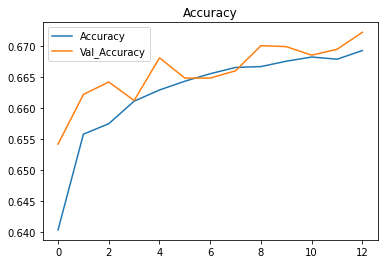

In [ ]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy');

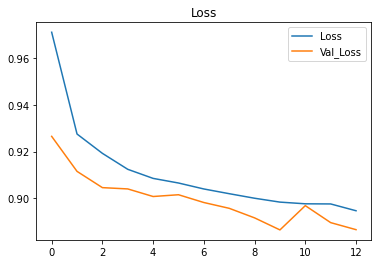

In [ ]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss');

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/animal_shelter_testing/an_engine_onehot.h5')

## One Hot Encoder Workflow

In [ ]:
# This input can't be sent to a model, the one hot encoder will
# preserve the structure of our previous inputs and allow us to 
# send variables at our model. 
# Using pandas get_dummies is not a reliable way to deal with user
# input as we would have to bring structures from our data into
# deployment. This increases the likelihood something will go wrong.
input = X.iloc[0]
input

animal_type                           Dog
color                        yellow white
breed                spinone italiano mix
intake_type                 Public Assist
intake_condition                   Normal
year_in                              2014
month_in                               12
day_in                             Friday
prev_adoption                           0
prev_transfer                           0
prev_ret_to_owner                       1
prev_rto_adopt                          0
prev_disposal                           0
prev_missing                            0
prev_relocate                           0
age_upon_outcome                        7
age_upon_intake                         7
sex_upon_intake             Neutered Male
sex_upon_outcome            Neutered Male
is_named_in                             1
Name: 0, dtype: object

In [ ]:
# we should get this output
y[0]

'Return to Owner'

In [ ]:
# "sanitize" the input, we need to reshape because...
# I'd show what it looks like, but visually it is not different 
# in this output
sanitized_input = input.values.reshape(1,-1)

In [ ]:
# due to the size of our data, sklearn will convert our
# array into a sparse matrix. This makes it more wieldy.
encoded_input = enc.transform(sanitized_input)
encoded_input

<1x2638 sparse matrix of type '<class 'numpy.float64'>'
	with 13 stored elements in Compressed Sparse Row format>

In [ ]:
# to see the categories
#enc.categories_

In [ ]:
# Predictions from the model
pred = model.predict(encoded_input)
pred

array([[6.7888260e-02, 3.7035442e-04, 4.5254317e-05, 3.9439112e-02,
        2.9435669e-05, 7.3359987e-13, 8.4773642e-01, 3.5551293e-05,
        4.4455681e-02]], dtype=float32)

In [ ]:
pred.round() 

array([[0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

In [ ]:
# success
labelencoder.classes_[-3] 

'Return to Owner'

# Time Predictions



In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/bpberry0324/animal_shelter_outcomes/main/datasets/main.csv')

In [ ]:
df['date_in'] = pd.to_datetime(df['datetime_in'], infer_datetime_format=True)
df['date_out'] = pd.to_datetime(df['datetime_out'], infer_datetime_format=True)

In [ ]:
df['time_spent'] = df['date_out'] - df['date_in']
df['time_spent'] = df['time_spent'].dt.total_seconds()

In [ ]:
adopted = df[df['outcome_type'] == 'Adoption']

In [ ]:
adopted = adopted.drop(columns=['datetime_in', 'datetime_out', 'name_out', 'name_in', 'day_out', 
                      'month_out', 'year_out', 'found_location', 'outcome_type', 'outcome_subtype',
                      'age_upon_outcome','sex_upon_outcome','is_named_out', 'date_in', 'date_out'])

In [ ]:
adopted.columns

Index(['animal_id_in', 'animal_type', 'color', 'breed', 'intake_type',
       'intake_condition', 'year_in', 'month_in', 'day_in', 'prev_adoption',
       'prev_transfer', 'prev_ret_to_owner', 'prev_rto_adopt', 'prev_disposal',
       'prev_missing', 'prev_relocate', 'age_upon_intake', 'sex_upon_intake',
       'is_named_in', 'time_spent'],
      dtype='object')

In [ ]:
X = adopted.drop(columns=['time_spent','animal_id_in'])
# predicting the hours?
y = adopted['time_spent'] / 360

In [ ]:
y.mean()

7821.188420640976

In [ ]:
enc = OneHotEncoder(drop='first')
enc.fit(X)
X = enc.transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=13, 
                                                    test_size=.2)
#sc = StandardScaler()
#X_train_sc = sc.fit_transform(X_train)
#X_test_sc = sc.transform(X_test)

In [ ]:
X_train.shape

(45692, 1973)

In [ ]:
type(X_train), type(X_test), type(y_train), type(y_test)

(scipy.sparse.csr.csr_matrix,
 scipy.sparse.csr.csr_matrix,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [ ]:
X_train = X_train.toarray()
X_test = X_test.toarray()

In [ ]:
def animal_outcome_engine():
  model = Sequential()
  model.add(Dense(512, activation='relu', 
                  input_dim=X_train.shape[1], 
                  kernel_regularizer=l2(.01)))
  model.add(Dropout(0.25))

  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.25))
  
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.25))

  model.add(Dense(1))
  model.compile(loss='mse', optimizer='adam', metrics=['mae'])
  return model

In [ ]:
model = animal_outcome_engine()
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, 
                           verbose=1, mode='auto')
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    epochs=50, 
                    batch_size=32,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/50
1428/1428 [==============================] - 15s 10ms/step - loss: 185311920.0000 - mae: 6523.1348 - val_loss: 172397296.0000 - val_mae: 6247.3164
Epoch 2/50
1428/1428 [==============================] - 14s 10ms/step - loss: 176281088.0000 - mae: 6193.6060 - val_loss: 171527024.0000 - val_mae: 5846.4019
Epoch 3/50
1428/1428 [==============================] - 15s 10ms/step - loss: 173516624.0000 - mae: 6098.5981 - val_loss: 170312464.0000 - val_mae: 6127.6875
Epoch 4/50
1428/1428 [==============================] - 13s 9ms/step - loss: 170802416.0000 - mae: 6028.2686 - val_loss: 170835568.0000 - val_mae: 6164.4971
Epoch 5/50
1428/1428 [==============================] - 13s 9ms/step - loss: 167815232.0000 - mae: 5955.9443 - val_loss: 169727408.0000 - val_mae: 6018.0518
Epoch 6/50
1428/1428 [==============================] - 13s 9ms/step - loss: 162661184.0000 - mae: 5867.4360 - val_loss: 184731408.0000 - val_mae: 7463.2129
Epoch 7/50
1428/1428 [==============================] -

# Binary Classification for Adoption

Seeing if we switch to only predicting adoptions if our results are better.

In [ ]:
testing_df = pd.read_csv('https://raw.githubusercontent.com/bpberry0324/animal_shelter_outcomes/main/datasets/main.csv')
testing_df = testing_df.drop(columns=['datetime_in', 'datetime_out', 'name_out', 'name_in', 'day_out', 
                                      'month_out', 'year_out', 'found_location', 'age_upon_outcome', 'sex_upon_outcome'])

X = testing_df.drop(columns=['animal_id_in','outcome_type','outcome_subtype',
                             'is_named_out'])
y = testing_df['outcome_type']

In [ ]:
y.unique()

array(['Return to Owner', 'Transfer', 'Relocate', 'Adoption',
       'Euthanasia', 'Died', 'Rto-Adopt', 'Missing', 'Disposal'],
      dtype=object)

In [ ]:
y = y.apply(lambda x: x if x=='Adoption' else 'Not Adopted')

In [ ]:
y.value_counts(normalize=True)

Not Adopted    0.550777
Adoption       0.449223
Name: outcome_type, dtype: float64

In [ ]:
enc = OneHotEncoder(drop='first')
enc.fit(X)
X = enc.transform(X)

In [ ]:
# making our label categorical
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=13, 
                                                    stratify=y,
                                                    test_size=.2)

In [ ]:
def animal_outcome_engine():
  model = Sequential()
  model.add(Dense(512, activation='relu', 
                  input_dim=X_train.shape[1], 
                  kernel_regularizer=l2(.0005)))
  model.add(Dropout(0.5))

  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
model = animal_outcome_engine()
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, 
                           verbose=1, mode='auto')
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    epochs=50, 
                    batch_size=64,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_12/dense_71/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_12/dense_71/embedding_lookup_sparse/Reshape:0", shape=(None, 512), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_12/dense_71/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


1590/1590 [==============================] - 29s 18ms/step - loss: 0.5855 - accuracy: 0.7040 - val_loss: 0.5583 - val_accuracy: 0.7247
Epoch 2/50
1590/1590 [==============================] - 29s 18ms/step - loss: 0.5686 - accuracy: 0.7200 - val_loss: 0.5546 - val_accuracy: 0.7353
Epoch 3/50
1590/1590 [==============================] - 29s 18ms/step - loss: 0.5659 - accuracy: 0.7217 - val_loss: 0.5518 - val_accuracy: 0.7306
Epoch 4/50
1590/1590 [==============================] - 30s 19ms/step - loss: 0.5644 - accuracy: 0.7238 - val_loss: 0.5501 - val_accuracy: 0.7318
Epoch 5/50
1590/1590 [==============================] - 30s 18ms/step - loss: 0.5624 - accuracy: 0.7236 - val_loss: 0.5538 - val_accuracy: 0.7299
Epoch 6/50
1590/1590 [==============================] - 30s 19ms/step - loss: 0.5614 - accuracy: 0.7258 - val_loss: 0.5491 - val_accuracy: 0.7350
Epoch 7/50
1590/1590 [==============================] - 30s 19ms/step - loss: 0.5607 - accuracy: 0.7255 - val_loss: 0.5549 - val_accura